In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from natsort import natsorted
import matplotlib as mpl

# Add function path
original_path = os.getcwd()
os.chdir(original_path)
function_path = './functions/'
sys.path.append(function_path)

# Import custom functions
from analysis_function import *
from kcc_constrain_function import *
from Plot_function import *
from f1_0_H_sum_multi_region_constrain import *
from f_IMP import *
from f_schemes import *
from ar6_area_weighted_cont_global import *


In [3]:
path = './saved_data/'

def load_xr_pickle(filename):
    with open(filename, "rb") as f:
        return pickle.load(f)

obs_all = load_xr_pickle(path + '0.1.HadCRUT5.Tas.anomalies.46AR6regions_7cont_1glob_175years_1850-2024.pkl')

obs_200runs_all = load_xr_pickle(path + '0.2.HadCRUT5.200runs.nonmasked.Tas.anomalies.46AR6regions_7cont_1glob_175years_1850-2024.pkl')

mod_all = load_xr_pickle(path + '0.4.Smoothed_His-ALL.25mods.mean.nonmasked.Tas.anomalies.46AR6regions_7cont_1glob_171years_1850-2020.pkl')

mod_sub_forcing = load_xr_pickle(path + '0.4.Smoothed_His-ANT.NAT.GHG.OA.10mods.mean.nonmasked.Tas.anomalies.46AR6regions_7cont_1glob_171years_1850-2020.pkl')

mod_all = xr.concat([mod_all,mod_sub_forcing],dim = 'forcing')

ln_mod_all = load_xr_pickle(path + '0.3.Large_ensembles.320runs.nonmasked.Tas.anomalies.46AR6regions_7cont_1glob_251years_1850-2100.pkl')

mod_45_pseudo = load_xr_pickle(path + '0.5.pseudo-model.15mod.run1-3.nonmasked.Tas.anomalies.46AR6regions_7cont_1glob_176years_1850-2025.pkl')

print_xarray_info(obs_all, obs_200runs_all, mod_all, ln_mod_all, mod_45_pseudo)


Array 1:
  Sizes: Frozen({'year': 175, 'region': 54})
  Coords: ['realization', 'year', 'region', 'abbrevs', 'names']

Array 2:
  Sizes: Frozen({'runs': 200, 'year': 175, 'region': 54})
  Coords: ['runs', 'year', 'region', 'abbrevs', 'names']

Array 3:
  Sizes: Frozen({'forcing': 5, 'model_name': 25, 'year': 176, 'region': 54})
  Coords: ['model_name', 'region', 'year', 'forcing', 'abbrevs', 'names']

Array 4:
  Sizes: Frozen({'model_run': 320, 'year': 251, 'region': 54})
  Coords: ['year', 'model_run', 'model_name', 'region', 'abbrevs', 'names']

Array 5:
  Sizes: Frozen({'model_run': 45, 'year': 176, 'region': 54})
  Coords: ['model_run', 'year', 'model_name', 'region', 'abbrevs', 'names']


In [4]:
from f_schemes import *

# -----------------------------------------
# Define time periods
# -----------------------------------------

ref_period = (1850, 1900)

warming_target_period1 = (2016, 2025)

# -----------------------------------------
# Define constraint schemes
# -----------------------------------------
region_groups = {
    'North and Central America': ['GIC', 'NWN', 'NEN', 'WNA', 'CNA', 'ENA', 'NCA', 'SCA', 'CAR'],
    'South America': ['NWS', 'NSA', 'NES', 'SAM', 'SWS', 'SES', 'SSA'],
    'Europe': ['NEU', 'WCE', 'EEU', 'MED'],
    'Africa': ['SAH', 'WAF', 'CAF', 'NEAF', 'SEAF', 'WSAF', 'ESAF', 'MDG'],
    'Asia': ['RAR', 'WSB', 'ESB', 'RFE', 'WCA', 'ECA', 'TIB', 'EAS', 'ARP', 'SAS'],
    'Australasia': ['SEA', 'NAU', 'CAU', 'EAU', 'SAU', 'NZ'],
    'Antarctica': ['EAN', 'WAN'],
    'Global land': ['LSAT']
}

scheme_reg_lsat = generate_global_regional_target_constraint_pairs(region_groups, global_abbrev='LSAT')

scheme_reg_lsat

[{'target_reg': 'GIC', 'constrain_used_reg': ['GIC', 'LSAT']},
 {'target_reg': 'NWN', 'constrain_used_reg': ['NWN', 'LSAT']},
 {'target_reg': 'NEN', 'constrain_used_reg': ['NEN', 'LSAT']},
 {'target_reg': 'WNA', 'constrain_used_reg': ['WNA', 'LSAT']},
 {'target_reg': 'CNA', 'constrain_used_reg': ['CNA', 'LSAT']},
 {'target_reg': 'ENA', 'constrain_used_reg': ['ENA', 'LSAT']},
 {'target_reg': 'NCA', 'constrain_used_reg': ['NCA', 'LSAT']},
 {'target_reg': 'SCA', 'constrain_used_reg': ['SCA', 'LSAT']},
 {'target_reg': 'CAR', 'constrain_used_reg': ['CAR', 'LSAT']},
 {'target_reg': 'NWS', 'constrain_used_reg': ['NWS', 'LSAT']},
 {'target_reg': 'NSA', 'constrain_used_reg': ['NSA', 'LSAT']},
 {'target_reg': 'NES', 'constrain_used_reg': ['NES', 'LSAT']},
 {'target_reg': 'SAM', 'constrain_used_reg': ['SAM', 'LSAT']},
 {'target_reg': 'SWS', 'constrain_used_reg': ['SWS', 'LSAT']},
 {'target_reg': 'SES', 'constrain_used_reg': ['SES', 'LSAT']},
 {'target_reg': 'SSA', 'constrain_used_reg': ['SSA', 'L

Processing region 0: Greenland/Iceland
 Constraining used region 0: ['GIC', 'LSAT']


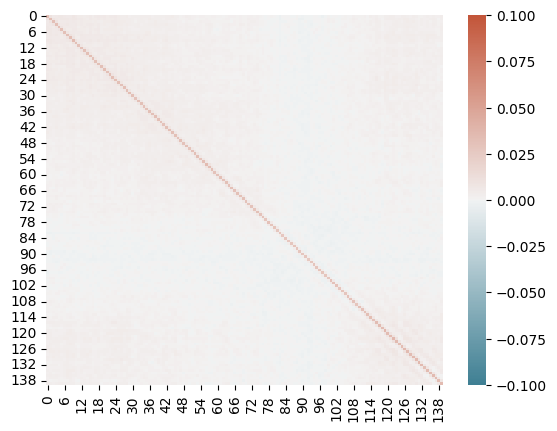

Processing region 1: N.W.North-America
 Constraining used region 1: ['NWN', 'LSAT']


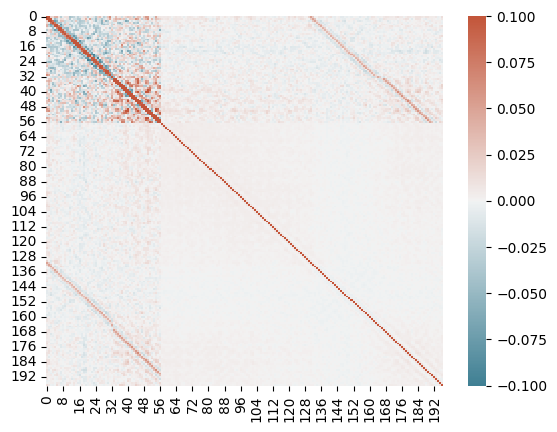

In [19]:
constrain_func = constrain_sum_reg
obs = obs_all
obs_200runs = obs_200runs_all
ln_mod = ln_mod_all
mod_his = mod_all
mod_da = mod_all.isel(region=slice(0, 2))
obs_ar6 = obs_all.isel(region=slice(0, 2))
region_names = list(mod_da.names[0:2].values)
forcing_list = mod_da.forcing  # xarray.DataArray
his_forcing = ['GHG', 'OA', 'NAT']
constrain_forcing_names=['GHG', 'OA']

prior_warm_lsat_region_GHG_OA, post_warm_lsat_region_GHG_OA, prior_smooth_lsat_region_GHG_OA, post_smooth_lsat_region_GHG_OA, obs_adj_lsat_region_GHG_OA = \
    process_all_regions(scheme_pairs, constrain_func, obs, obs_200runs, ln_mod, mod_his, mod_da, obs_ar6, region_names, forcing_list, his_forcing, constrain_forcing_names, reg_id = slice(0, len(region_names)), calc_smoothed = True, print_constraint_regions = True)
